**Set environment**

In [2]:
suppressMessages(suppressWarnings(source("../run_config_project_sing.R")))
library(pheatmap)
show_env()

You are working on        Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
REPO DIRECTORY (FD_REPO): /data/reddylab/Kuei/repo 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/work 
DATA DIRECTORY (FD_DATA): /data/reddylab/Kuei/data 

You are working with      ENCODE FCC 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC 
PROJECT RESULTS (FD_RES): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/results 
PROJECT SCRIPTS (FD_EXE): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/scripts 
PROJECT DATA    (FD_DAT): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/data 
PROJECT NOTE    (FD_NBK): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/notebooks 
PROJECT DOCS    (FD_DOC): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/docs 
PROJECT LOG     (FD_LOG): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/log 
PROJECT REF     (FD_REF): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/references 



## Import data

In [3]:
txt_fdiry = file.path(
    FD_RES, 
    "region_annotation", 
    "fcc_astarr_macs_input_overlap",
    "summary_v2"
)
txt_fname = "matrix.umap.cluster.cres_vote1_gcfilter.chipseq_full.fcc.tss.tsv"
txt_fpath = file.path(txt_fdiry, txt_fname)

dat = read_tsv(txt_fpath, show_col_types = FALSE)

dat_region_merge = dat
print(dim(dat))
head(dat, 3)

[1] 87610   540


Region,UMAP1,UMAP2,Cluster,ASTARR_A,WSTARR_A,LMPRA_A,TMPRA_A,ASTARR_R,WSTARR_R,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:10038-10405,-21.87767,-9.176196,39,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:16025-16338,-12.15321,-12.879920,20,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
chr1:115429-115969,-11.02704,-3.031374,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


In [4]:
dat = dat_region_merge
vec = colnames(dat)
vec = vec[-c(1:4)]
vec_txt_feature = vec
print(length(vec))
head(vec)

[1] 536


[1] "ASTARR_A" "WSTARR_A" "LMPRA_A"  "TMPRA_A"  "ASTARR_R" "WSTARR_R"

In [5]:
vec_num_cluster = 0:10

In [6]:
lst_outer = list()
for (num_cluster in vec_num_cluster){
    
    lst_inner = list()
    for (txt_feature in vec_txt_feature){
        dat = dat_region_merge
        dat = dat %>% dplyr::mutate(Label_Cluster = as.integer(Cluster == num_cluster))
        dat[,"Label_Feature"] = dat[,txt_feature]

        dat = dat %>% dplyr::select(Label_Cluster, Label_Feature) 
        mat = table(dat$Label_Cluster, dat$Label_Feature)
        mat = mat + 1
        fit = fisher.test(mat)
        
        lst_inner[[txt_feature]] = fit
    }
    lst_outer[[as.character(num_cluster)]] = lst_inner
}

lst_fit_fisher = lst_outer

In [7]:
mat

   
        0     1
  0 84303  1583
  1  1725     3

In [8]:
lst_outer = lst_fit_fisher

lst = lapply(lst_outer, function(lst_inner){
    lst = lapply(lst_inner, function(fit){
        res = c(fit$estimate, fit$p.value)
        names(res) = c("OddsRatio", "Pval")
    return(res)
    })
    
    dat = bind_rows(lst, .id = "Feature")
    return(dat)
})
dat = bind_rows(lst, .id = "Cluster")
dat = dat %>% 
    dplyr::mutate(Log2OR  = log2(OddsRatio)) %>%
    dplyr::mutate(PvalAdj = p.adjust(Pval, method = "BH")) %>%
    dplyr::mutate(NLog10P = -log10(PvalAdj))
                            
dat_res_fisher = dat
print(dim(dat))
head(dat)

[1] 5896    7


Cluster,Feature,OddsRatio,Pval,Log2OR,PvalAdj,NLog10P
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,ASTARR_A,3.3273008,0.000000e+00,1.73435232,0.000000e+00,Inf
0,WSTARR_A,0.8056078,1.404379e-28,-0.31185038,2.272912e-28,27.64341738
0,LMPRA_A,2.0274165,2.173062e-287,1.01964250,1.697003e-286,285.77031730
0,TMPRA_A,1.0203037,8.218387e-01,0.02899868,8.288678e-01,0.08151475
0,ASTARR_R,0.4075534,0.000000e+00,-1.29493911,0.000000e+00,Inf
0,WSTARR_R,0.7585814,3.456772e-08,-0.39862405,4.231083e-08,7.37354843


In [9]:
dat = dat_res_fisher
vec = dat$Log2OR
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-12.3597  -4.0624  -2.3324  -2.3252  -0.6156  12.5805 

In [10]:
dat = dat_res_fisher
vec = dat$NLog10P
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.03   37.46   65.11   97.77  322.08 

In [11]:
dat = dat_res_fisher
dat = dat %>% 
    dplyr::mutate(Log2OR = ifelse(is.infinite(Log2OR), 1000, Log2OR)) %>%
    dplyr::select(Cluster, Feature, Log2OR) %>% 
    tidyr::spread(Feature, Log2OR) %>%
    column_to_rownames(var = "Cluster")

head(dat)

,ADNP,AFF1,AGO1,ARHGAP35,ARID1B,ARID2,ARID3A,ARID3B,ARID4B,ARNT,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2.3266431,1.8058422,-2.803714,0.9199652,5.5929843,-0.2352052,2.96225947,-0.2807443,-0.4641002,2.5977994,⋯,-0.333610801,-0.3214365,0.2098002,1.339948,1.795810,-0.261277,-1.004310,1.213214,0.2652534,-0.7203077
1,1.1184988,2.9011249,4.684664,3.1991039,0.9896162,1.2867427,0.68119511,3.2426813,5.2562319,2.1709530,⋯,1.157390790,3.0187952,0.3672853,1.079234,2.340386,4.041042,4.580383,3.387293,2.7240180,4.6286137
10,-0.9614026,-0.4243588,-2.260160,-1.4823913,-1.8792680,-3.1274834,-3.44345589,-1.5884686,-1.9748962,-2.0623256,⋯,-0.008618238,-3.6172102,-0.4953989,-1.956936,-2.121083,-2.241901,-2.868879,-2.537379,-2.6973497,-3.4323647
2,-1.0744456,-1.9665082,-1.467307,-1.6980442,-2.3728879,3.6878175,0.01729104,-1.7562621,-1.6389838,-0.7888076,⋯,-0.261249930,-2.4144562,-0.8671389,-2.549528,-2.771194,-1.418731,-2.591767,-1.501030,-2.4440211,-1.0665320
3,-0.1922525,-1.3730211,-3.557057,-2.1254231,1.6989220,-2.3364174,-0.44510256,-3.4572586,-2.7655916,-1.2290942,⋯,-0.956593835,-3.5870512,-2.1469919,-1.421452,-1.013279,-2.051856,-3.758435,-1.665966,-1.7311803,-3.1770457
4,-1.3941137,-2.8043544,-3.375555,-3.2368652,-1.7577582,-4.2584790,-2.95573489,-3.7070645,-3.3896606,-3.1796055,⋯,-1.338466585,-2.9387995,-3.8425056,-2.054202,-3.084269,-3.241889,-5.206172,-2.327128,-3.7079799,-5.3497189


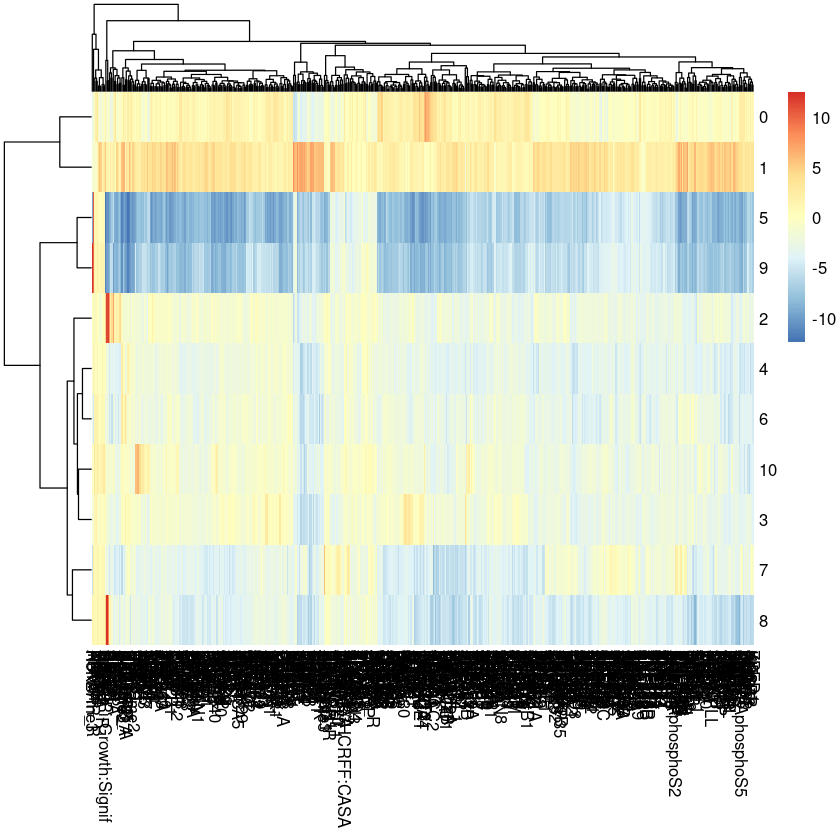

In [12]:
pheatmap(dat)

In [12]:
brewer.pal(n = 7, name = "RdYlBu")

[1] "#D73027" "#FC8D59" "#FEE090" "#FFFFBF" "#E0F3F8" "#91BFDB" "#4575B4"

In [13]:
vec_num_breaks = seq(-12, 12, by = 0.1)

vec = brewer.pal(n = 7, name = "RdYlBu")
vec = colorRampPalette(rev(vec))(length(vec_num_breaks))
vec_txt_colors = vec

In [14]:
vec = vec_txt_feature
idx = str_detect(vec, "p")
vec[idx]

[1] "POLR2AphosphoS2" "POLR2AphosphoS5"

In [15]:
vec = c("CTCF", "SMC3", "RAD21", "TSS", "POLR2A", "EP300", 
        'H3K27ac', 'H3K4me1', 'H3K4me2', 'H3K4me3')
mat = dat[, vec]
mat

,CTCF,SMC3,RAD21,TSS,POLR2A,EP300,H3K27ac,H3K4me1,H3K4me2,H3K4me3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-1.1865833,-1.5540431,0.1078938,-3.148470,1.1115781,4.1529569,1.9866132,2.5906056,1.8954334,1.3749240
1,1.7846442,0.7740328,1.2017797,7.971934,5.3684968,1.1630171,4.5172657,2.7724295,6.3402513,6.4297320
10,-0.8967119,-1.2394096,-1.1999962,-4.041520,-2.0394909,-2.5384137,-1.1891345,-0.3660570,0.0568613,-0.5812587
2,11.5446703,7.4072120,11.7021402,-4.959253,-1.9425299,-1.9400937,-2.7838771,-0.9164309,-1.0529062,-1.4498280
3,-1.6031223,-2.7699084,-1.4379960,-4.705469,-1.4510020,0.2421348,0.7665492,1.0053098,0.3362659,-0.7385246
4,-1.7747737,-4.7347748,-2.3933703,-3.424729,-2.1839980,-3.1354213,-0.3186523,1.8411061,0.8518435,0.1264161
5,-10.5709498,-9.3795984,-10.5571179,-8.649652,-10.2864270,-9.9137716,-9.7545227,-12.1771005,-10.2330495,-9.6515132
6,-2.3814420,-5.0295246,-2.5155492,-3.376014,-0.6948543,-2.3193121,0.2754174,-1.1474672,0.9829771,0.8906241
7,-2.1679603,-4.6642881,-3.3591506,-3.859700,2.1779140,-5.7512295,-2.0415232,-0.7755689,-4.0184355,-4.1753646


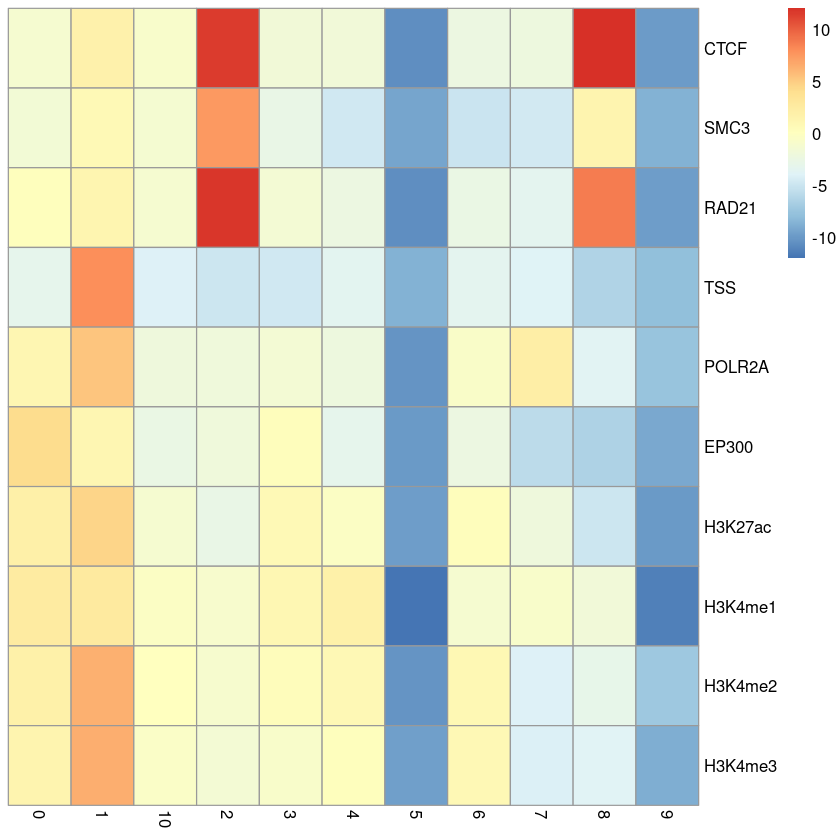

In [16]:
options(repr.plot.height = 7, repr.plot.width=7)
pheatmap(
    t(mat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    cluster_rows = FALSE,
    cluster_cols = FALSE
)

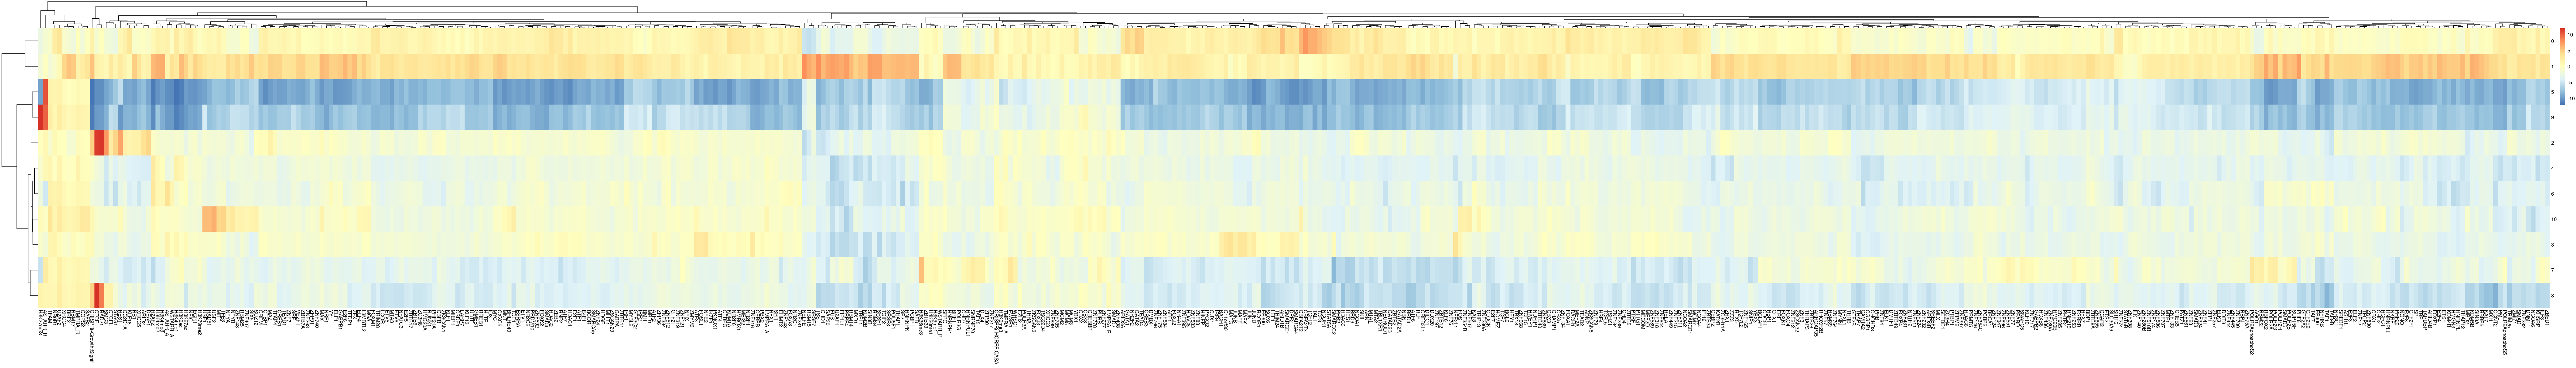

In [18]:
options(repr.plot.height = 10, repr.plot.width=70)
pheatmap(
    dat,
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    treeheight_row = 70
)

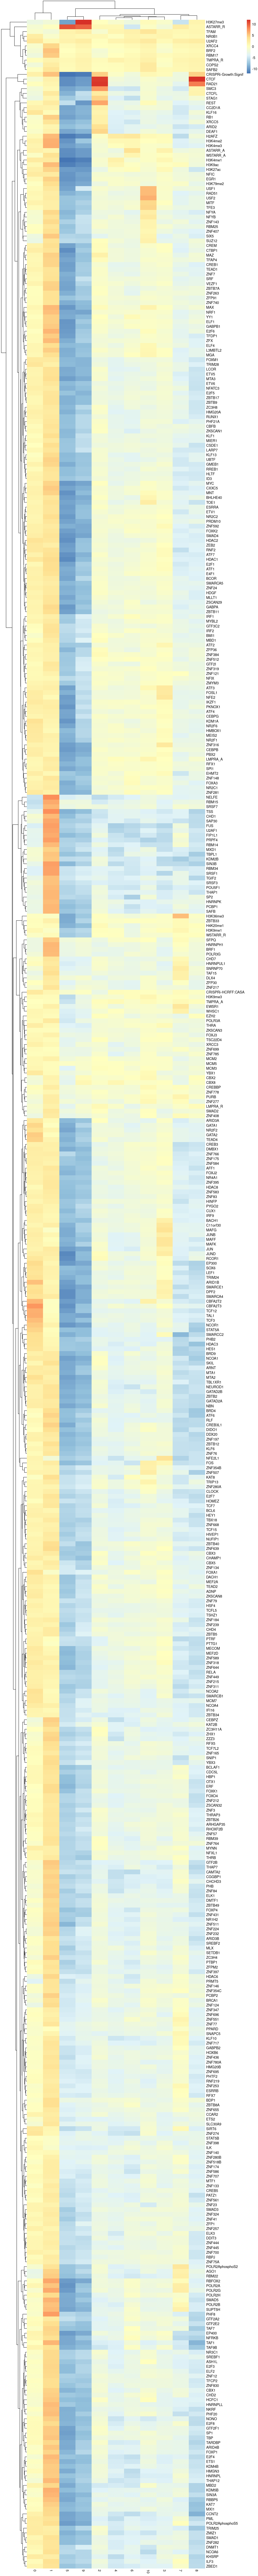

In [17]:
options(repr.plot.height = 100, repr.plot.width=10)
pheatmap(
    t(dat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    treeheight_row = 70
)

In [51]:
dat = data.frame(x = c(1, Inf, NA))
dat = dat %>% 
    dplyr::mutate(X= ifelse(is.infinite(x), 1000, x))

print(dat)

    x    X
1   1    1
2 Inf 1000
3  NA   NA


In [45]:
is.na(dat$x)

[1] FALSE FALSE  TRUE

In [46]:
is.infinite(dat$x)

[1] FALSE  TRUE FALSE

In [38]:
pheatmap(dat)

ERROR: Error in hclust(d, method = method): NA/NaN/Inf in foreign function call (arg 10)


In [ ]:
breaksList = seq(-0.5, 1, by = 0.2)

In [21]:
dat = dat_res_fisher
vec = dat$NLog10P
idx = is.infinite(vec)
vec = vec[!idx]
summary(vec)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.03   37.46   65.11   97.77  322.08 

In [22]:
dat = dat_res_fisher
dat = dat %>% 
    dplyr::mutate(NLog10P = ifelse(is.infinite(NLog10P), 1000, NLog10P)) %>%
    dplyr::select(Cluster, Feature, NLog10P) %>% 
    tidyr::spread(Feature, NLog10P) %>%
    column_to_rownames(var = "Cluster")

head(dat)

,ADNP,AFF1,AGO1,ARHGAP35,ARID1B,ARID2,ARID3A,ARID3B,ARID4B,ARNT,⋯,ZNF778,ZNF780A,ZNF785,ZNF79,ZNF83,ZNF830,ZNF84,ZSCAN29,ZSCAN32,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1000.000000,1000.00000,194.84041,27.575734,1000.00000,4.619753,1000.000000,2.441044,29.31106,1000.00000,⋯,0.2771464,1.228012,0.4865235,64.496776,1000.00000,4.632959,31.96349,230.89850,3.469446,10.59407
1,138.134838,1000.00000,1000.00000,1000.000000,258.28964,148.931481,47.122126,1000.000000,1000.00000,1000.00000,⋯,3.1571462,131.630305,0.9391725,35.497901,1000.00000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
10,9.011049,3.80727,17.01516,4.231189,84.29916,30.188638,43.190618,4.967808,38.26621,41.26661,⋯,0.0000000,3.708784,0.1683938,6.102769,23.47398,17.660220,14.79080,41.74226,12.530039,9.57536
2,51.956571,209.82875,50.00033,25.030440,1000.00000,1000.000000,0.114645,28.045741,152.55580,48.10490,⋯,0.1227685,14.383922,1.8051752,42.248949,165.05169,49.606174,70.58816,110.12816,59.110204,12.32049
3,2.078940,89.06367,97.01861,23.518701,1000.00000,83.842677,8.533439,40.624308,208.99080,72.09863,⋯,0.5797713,14.334167,4.2383814,14.636207,30.00082,57.959842,68.96974,91.19488,27.674382,33.90440
4,36.886011,148.25812,60.79243,23.566469,183.78861,92.714465,92.359647,27.998523,165.47316,160.22083,⋯,0.5911561,7.941448,4.6150125,15.486384,84.04267,61.151766,53.68443,92.06819,39.709267,30.21848


In [23]:
vec = c("CTCF", "SMC3", "RAD21", "TSS", "POLR2A", "EP300", 
        'H3K27ac', 'H3K4me1', 'H3K4me2', 'H3K4me3')
mat = dat[, vec]
mat

,CTCF,SMC3,RAD21,TSS,POLR2A,EP300,H3K27ac,H3K4me1,H3K4me2,H3K4me3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1000.00000,292.69712,3.939274,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.0000000,1000.000000
1,1000.00000,105.98592,1000.000000,1000.00000,1000.00000,305.707245,1000.000000,1000.000000,1000.0000000,1000.000000
10,25.18227,24.58397,40.918067,61.59720,80.71184,87.066763,43.573556,6.643281,0.3572104,12.103088
2,1000.00000,1000.00000,1000.000000,1000.00000,1000.00000,322.075766,1000.000000,177.436265,200.6143643,289.697692
3,235.95867,262.83269,197.180858,254.93506,177.78186,7.183501,87.588649,142.698952,18.1021530,64.124541
4,182.63847,263.79047,275.317345,133.56036,214.01056,265.939649,9.607114,276.106443,76.3577200,1.967879
5,1000.00000,254.69303,1000.000000,158.10661,1000.00000,1000.000000,1000.000000,1000.000000,1000.0000000,1000.000000
6,188.49185,184.84494,200.585583,89.99085,23.66490,130.207773,5.727596,93.753374,70.5973867,55.710093
7,145.87695,155.25108,240.292273,86.93991,292.01410,236.660429,146.145456,38.980437,1000.0000000,303.622188


In [24]:
vec_num_breaks = seq(0, 400, by = 0.1)

vec = brewer.pal(n = 7, name = "Reds")
vec = colorRampPalette(vec)(length(vec_num_breaks))
vec_txt_colors = vec

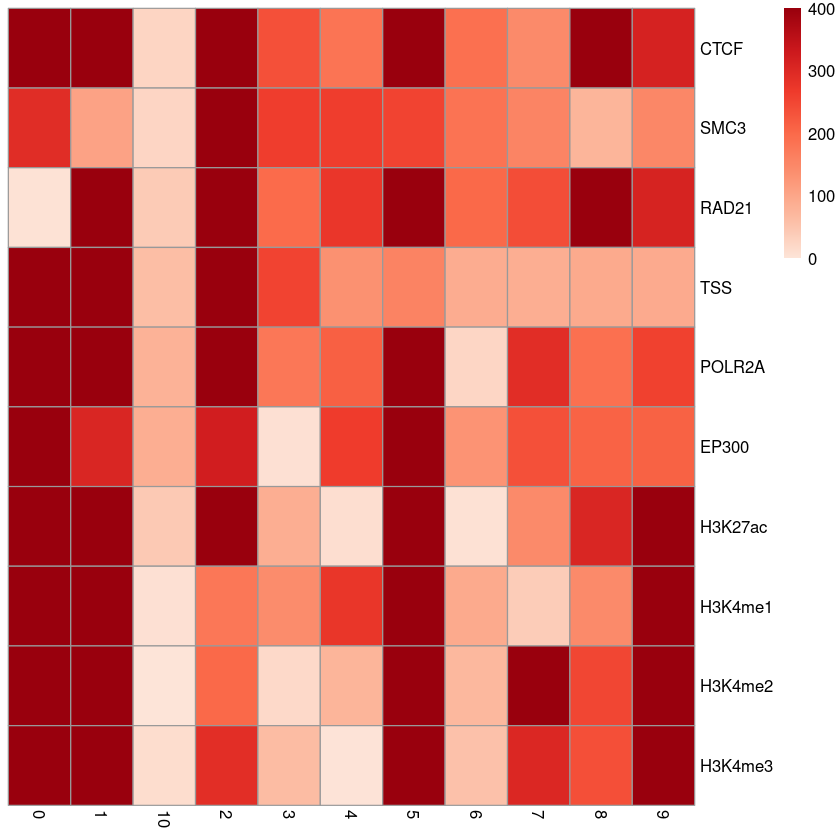

In [25]:
options(repr.plot.height = 7, repr.plot.width=7)
pheatmap(
    t(mat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    cluster_rows = FALSE,
    cluster_cols = FALSE
)

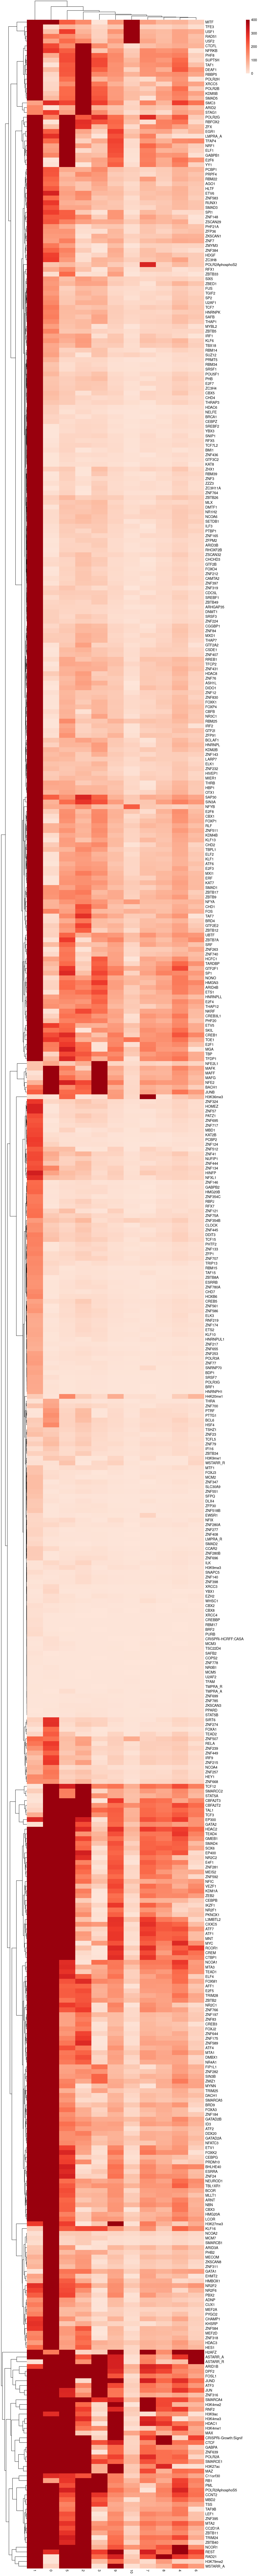

In [26]:
options(repr.plot.height = 100, repr.plot.width=10)
pheatmap(
    t(dat),
    color  = vec_txt_colors,
    breaks = vec_num_breaks,
    treeheight_row = 70
)